In [23]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy.special import factorial
from scipy.stats import ttest_ind

<h1 align='center'>Статистика регистрации частиц</h1>

   1) Для каждой из измеренных серий рассчитываются оценки среднего значения числа отсчетов $\mu^\ast$ и стандартной ошибки среднего по формуле:

$$\mu^\ast = \frac{1}{N} \sum_{i=1}^N{x_i};  \sigma_\mu^\ast = \frac{\sigma^\ast}{\sqrt{N}} = \sqrt{\frac{\sum_{i=1}^N{(\mu^\ast -x_i)^2}}{\N(N-1)}}$$

Поскольку в первом случае оценка стандартной ошибки не зависит от распределения, а во втором явно предполагается, что величина подчиняется распределению Пуассона, то из сравнения двух оценок стандартной ошибки можно сделать вывод о том, соответствует ли наблюдаемое распределение закону Пуассона.

Также необходимо найти среднюю скорость счета и ее погрешность по формуле:

$$I=\frac{\mu}{\Delta t}$$

2) Результаты измерений в двух упражнениях изображаются в виде гистограмм распределения частот. Для удобства сравнения гистограммы обоих серий измерений строятся на одном листе друг над другом, с одинаковыми пределами и масштабом по оси $X$ и с одинаковой шириной канала $\Delta x$. При построении гистограмм исходные значения частот сначала заносятся в тетрадь в виде таблицы.

3) На одном графике с каждой гистограммой изображаются: точками — теоретические значения вероятностей распределения Пуассона с параметром $\mu = \mu^\ast$, сплошнойкривой — нормальное распределение с параметрами $\mu = \mu^\ast, \sigma =\sqrt{\mu^\ast}$

4) Строятся эмпирические функции распределений выборок обоих упражнений и с помощью критерия Колмогорова проверяется однородность двух выборок.

Затем находится максимальное значение модуля разности эмпирических распределений и рассчитывается значение статистики $t$. Если $t$ превышает значение $K_{\alpha}$ при заданном уровне доверия $1−\alpha$, то гипотеза однородности распределений отвергается, и делается вывод, что распределения в первом и втором упражнениях отличаются, т.е. неизвестный источник является радиоактивным.

Полученные эмпирические функции распределения изображены графически на одном графике. Поскольку число точек по оси $X$ велико, рекомендуется строить график на компьютере. Если график строится вручную, то достаточно наносить точки через каждые 3—5 значений

5) Если результатом проверки однородности выборок стал вывод о том, что источник является радиоактивным, то нужно определить скорость счета событий от источника, пользуясь формулой $I_{full} = I_{backgraund} + I_{truth}$.

6) Если проверка показала отсутствие радиоактивного изотопа в образце, то измерения из второго упражнения используются для уточнения значения скорости счета фоновых частиц.

In [38]:
#различные функции для пострения kde гистограмм
def std(data):
    return np.sqrt(((data - np.mean(data)) ** 2).sum() / (len(data) * (len(data) - 1)))


def poiss(lam, d_):
    return np.exp(-lam) * lam ** d_ / factorial(d_)


def norm(mean, std, d_):
    return 1 / (np.sqrt(2 * np.pi) * std) * np.exp(-(d_ - mean) ** 2 / (2 * std ** 2))


def raspr(data):
    l = []
    for i in data:
        l.append(data[data < i].shape[0] / len(data))
    return np.array(l)


In [25]:
prom_1 = np.linspace(20, 50, 1000)
prom_2 = np.linspace(20, 60, 1000)

#экспериментальные данные
data_1 = np.array(
    [33, 27, 37, 35, 37, 35, 27, 27, 27, 33, 36, 30, 30, 39, 30, 32, 33, 33, 33, 34, 37, 29, 33, 36, 42, 32, 32, 38, 44,
     40, 34, 33, 31, 36, 26, 39, 32, 30, 36, 44, 26, 33, 37, 26, 34, 44, 33, 33, 35, 22, 42, 35, 33, 39, 37, 30, 46, 30,
     25, 29, 49, 36, 33, 33, 51, 34, 37, 38, 41, 39, 29, 45, 37, 38, 33, 33, 47, 29, 29, 23, 30, 28, 27, 50, 36, 27, 35,
     33, 40, 23, 35, 36, 27, 41, 30, 38, 25, 47, 31, 34])

data_2 = np.array(
    [33, 37, 49, 37, 37, 46, 46, 40, 46, 34, 40, 46, 40, 35, 41, 42, 42, 38, 45, 48, 34, 34, 32, 40, 40, 42, 44, 48, 48,
     43, 36, 48, 46, 47, 34, 39, 47, 41, 47, 43, 43, 31, 38, 45, 41, 40, 37, 51, 46, 38, 48, 34, 31, 43, 48, 40, 40, 44,
     42, 34, 39, 39, 44, 45, 43, 40, 46, 45, 46, 33, 29, 42, 39, 45, 36, 37, 37, 51, 45, 39, 46, 54, 27, 33, 40, 48, 43,
     47, 41, 40, 48, 40, 33, 31, 46, 43, 45, 42, 37, 37])


In [35]:
#приведение данных к нужному виду
df = pd.DataFrame({'noise': data_1, 'potassium': data_2})
df_ = df.stack().reset_index().drop('level_0', axis=1)
df_ = df_.rename(columns={0: 'noise VS potassium', 'level_1': 'types'})

ddf_1 = pd.DataFrame({'F(x)': raspr(data_1), 'data': data_1})
ddf_1['types'] = 'noise'

ddf_2 = pd.DataFrame({'F(x)': raspr(data_2), 'data': data_2})
ddf_2['types'] = 'potassium'

new_ddf = pd.concat([ddf_1, ddf_2])
print('1-е упражнение:')
print(df_.head())
print('*'*50)
print('2-е упражнение:')
print(new_ddf.head())

1-е упражнение:
       types  noise VS potassium
0      noise                  33
1  potassium                  33
2      noise                  27
3  potassium                  37
4      noise                  37
**************************************************
2-е упражнение:
   F(x)  data  types
0  0.35    33  noise
1  0.08    27  noise
2  0.69    37  noise
3  0.56    35  noise
4  0.69    37  noise


/Users/vadimvorobev/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/vadimvorobev/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


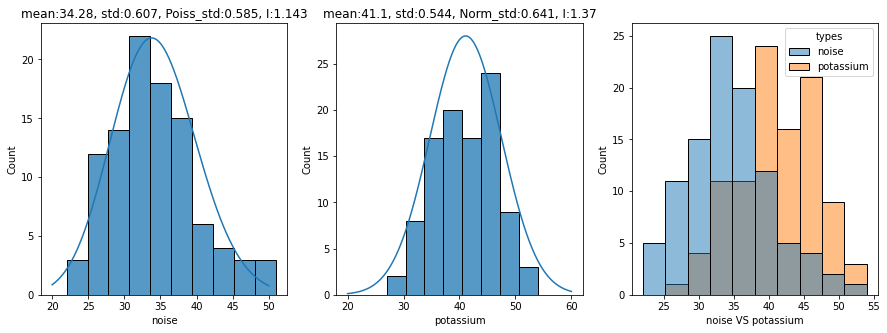

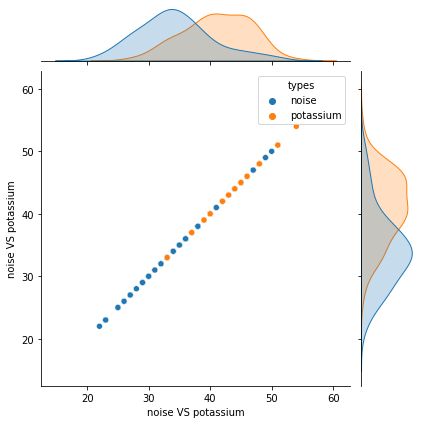

Ttest_indResult(statistic=-8.364707273539448, pvalue=1.0673263896343855e-14)
K: 3.5355339059327378


In [42]:
fig, axis = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df['noise'], ax=axis[0])
sns.lineplot(prom_1, 320 * poiss(np.mean(data_1), prom_1), ax=axis[0])
axis[0].set_title(
    'mean:{}, std:{}, Poiss_std:{}, I:{}'.format(round(np.mean(data_1), 3), round(std(data_1), 3),
                                                 round(np.sqrt(np.mean(data_1) / len(data_1)), 3),
                                                 round(np.mean(data_1) / 30, 3)))

sns.histplot(df['potassium'], ax=axis[1])
sns.lineplot(prom_2, 450 * norm(41.1, np.sqrt(41.1), prom_2), ax=axis[1])
axis[1].set_title(
    'mean:{}, std:{}, Norm_std:{}, I:{}'.format(round(np.mean(data_2), 3), round(std(data_2), 3),
                                                round(np.sqrt(np.mean(data_2) / len(data_2)), 3),
                                                round(np.mean(data_2) / 30, 3)))

sns.histplot(data=df_, x='noise VS potassium', hue='types', ax=axis[2])
sns.jointplot(data=df_, x=df_['noise VS potassium'], y=df_['noise VS potassium'], hue='types')

plt.show()

print(ttest_ind(data_1, data_2))
print('K: {}'.format(np.sqrt(len(data_1) * len(data_2) / (len(data_1) + len(data_2))) * 0.5))


In [39]:
1.37-1.143

0.2270000000000001

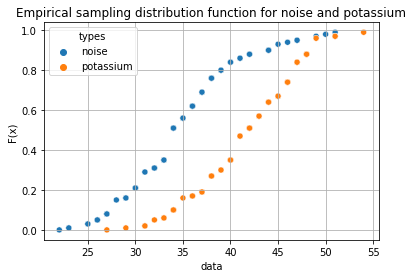

In [29]:
sns.scatterplot(data=new_ddf, x='data', y='F(x)', hue='types')
plt.title('Empirical sampling distribution function for noise and potassium')
plt.grid()

<h1 align='center'>Основыне итоги работы</h1>

1) Набрана статистика для двух случаев (с удобрением и без), посчитаны: среднее значения числа отсчетов, стандартная ошибка, отклонение по Поуассону

<h5 align='center'>1 упражнение:</h5>
$$\bar{x}=34.28$$
$$\sigma_x^\ast = 0.607$$
$$\sigma_n = 0.585$$

<h5 align='center'>2 упражнение:</h5>
$$\bar{x}=41.1$$
$$\sigma_n = 0.544$$
$$\sigma_n = 0.641$$
2) Определены скорости счёта событий:

$$I_{background}=(1.143\pm0.011)\space c^{-1}$$
$$I_{truth}=(0.227\pm0.012)\space c^{-1}$$
$$I_{full}=(1.370\pm0.011)\space c^{-1}$$
3) Построены гистограммы частот с наложением теоритического распределения Пуассона и Гаусса

4) Для обоих измерений построены эмпиричекские функции распределения и проверен критерий Колмогорова: $$t=0.5; K_\alpha=3.536\space\space\space\space(1-\alpha=0.9999)$$

Распределения в обоих упражнениях неоднородны с вероятностью 0,9999 $\Rightarrow$ источник радиоактивен

5) Дана оценка вероятности регистрации $\beta-$распадов изотопа $^{40}K$ детектором$$P=12.1\%$$